In [3]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader

sys.path.append('...')  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [4]:
# import "tesla_driving_temp_data.csv" dataset
df = pd.read_csv('tesla_driving_temp_data.csv')

In [5]:
# Sort the data by date
df = df.sort_values(by="date")
#print(df)

In [6]:
# Interpolate the missing data
df['outside_temp'] = df['outside_temp'].interpolate()
df['speed'] = df['speed'].interpolate()
#print(df) 

In [7]:
#save interpolated and sorted dataset
df.to_csv('tesla_driving_temp_data_intrp_sorted.csv')

In [8]:
# Extract features and labels
# [power, speed, battery_level, outside_temp] => [battery_temperature]

df_x = df[["power","speed", "battery_level", "outside_temp"]]
df_y = df[["battery_temperature"]]

In [10]:
df_x_tensor = (torch.tensor(df_x.values)).float()
df_y_tensor = torch.tensor(df_y.values).float()

torch.Size([445266, 4])
torch.Size([445266, 1])


In [11]:
# MLP model

lb = torch.min(df_x_tensor,0).values.numpy()
ub = torch.max(df_x_tensor,0).values.numpy()

model = pf.models.MLP(input_size=4,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)

model.cuda()

In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = torch.nn.MSELoss()

Streaming output truncated to the last 5000 lines.
Epoch  10000 Loss  0.9028922915458679
Epoch  10001 Loss  0.902702271938324
Epoch  10002 Loss  0.9025127291679382
Epoch  10003 Loss  0.9023232460021973
Epoch  10004 Loss  0.9021342396736145
Epoch  10005 Loss  0.9019456505775452
Epoch  10006 Loss  0.9017574191093445
Epoch  10007 Loss  0.9015698432922363
Epoch  10008 Loss  0.9013831615447998
Epoch  10009 Loss  0.9011974930763245
Epoch  10010 Loss  0.901013195514679
Epoch  10011 Loss  0.9008310437202454
Epoch  10012 Loss  0.9006516933441162
Epoch  10013 Loss  0.9004756808280945
Epoch  10014 Loss  0.9003047943115234
Epoch  10015 Loss  0.9001396894454956
Epoch  10016 Loss  0.8999830484390259
Epoch  10017 Loss  0.8998357057571411
Epoch  10018 Loss  0.8997012376785278
Epoch  10019 Loss  0.8995777368545532
Epoch  10020 Loss  0.8994683623313904
Epoch  10021 Loss  0.8993628025054932
Epoch  10022 Loss  0.8992579579353333
Epoch  10023 Loss  0.899127721786499
Epoch  10024 Loss  0.8989629149436951
Ep

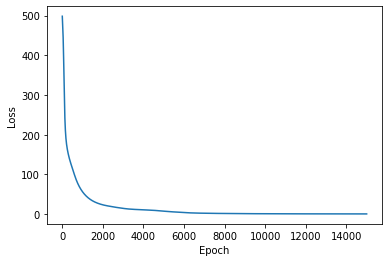

In [13]:
# Training
x_data_plot=[]
y_data_plot=[]
for epoch in range(15000):
    optimizer.zero_grad()
    prediction = model(df_x_tensor.cuda())
    loss = criterion(prediction,df_y_tensor.cuda())
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "Loss ", loss.item())
    x_data_plot.append(epoch)
    y_data_plot.append(loss.item())

# Make the plot of loss vs epoch
plt.plot(x_data_plot,y_data_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.show()

In [14]:
# Make a prediction
pred = model(df_x_tensor.float().cuda())
pred = pred.detach().cpu().numpy()

df_y_tensor = df_y_tensor.numpy()
#print(np.concatenate([df_y_tensor_np, pred],axis = 1))
print('relative l2 norm: ', np.linalg.norm(df_y_tensor-pred) / np.linalg.norm(df_y_tensor))

relative l2 norm:  0.031378634


In [15]:
# Visualisation

figure(figsize=(10, 8), dpi= 1440)

plt.plot(pred, '--')
plt.plot(df_y_tensor, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.ylabel('Temperature / °C')
plt.show()